In [ ]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt

# --- Load model ---
model_path = "/srv/scratch2/taylor.4264/odd_emu/production_models/learned_model_rhom_zchunk_00.eqx"
model_template = eqx.nn.MLP(in_size=265, out_size=262, width_size=512, depth=4, key=jax.random.PRNGKey(0))
model = eqx.tree_deserialise_leaves(model_path, model_template)

# --- Normalization constants (must match training script) ---
H_mean = ...           # load or hardcode H_mean used during training
H_std = ...            # same for H_std
log_rho_mean = ...     # and for rho
log_rho_std = ...

# --- Load external input ---
z_grid = jnp.load("/srv/scratch2/taylor.4264/odd_emu/production_run/merged/z_0.npy")
Hz = jnp.load("/srv/scratch2/taylor.4264/odd_emu/production_run/merged/Hz_0.npy")  # shape: (Nz,)
rho_m = jnp.load("/srv/scratch2/taylor.4264/odd_emu/production_run/merged/rho_m_0.npy")  # shape: (Nz,)
pk_init = jnp.load("path_to_pk_at_zinit.npy")  # shape: (262,)

# --- Prepare RHS ---
def rhs(t, y, args):
    model, H_fn, rho_fn = args
    H = (H_fn(t) - H_mean) / H_std
    log_rho = (jnp.log10(rho_fn(t) + 1e-30) - log_rho_mean) / log_rho_std
    z = jnp.array([t])
    return model(y, H[None], log_rho[None], z)[0]

# --- Interpolation for H(z) and rho(z) ---
from jax.experimental import interpolation

H_interp = interpolation.interp1d(z_grid, Hz)
rho_interp = interpolation.interp1d(z_grid, rho_m)

# --- ODE solve setup ---
P0 = jnp.log1p(pk_init)  # use log(1 + P) as in training
z0, z1 = float(z_grid[0]), float(z_grid[-1])  # decreasing z
solver = Dopri5()
term = ODETerm(rhs)
saveat = SaveAt(ts=z_grid)

# --- Solve ODE ---
sol = diffeqsolve(
    term,
    solver,
    t0=z0,
    t1=z1,
    dt0=-1e-2,  # negative dt to integrate forward in time
    y0=P0,
    args=(model, H_interp, rho_interp),
    saveat=saveat
)

# --- Output result ---
Pk_pred = jnp.expm1(sol.ys)  # shape: (Nz, 262)

FileNotFoundError: [Errno 2] No such file or directory: '/srv/scratch2/taylor.4264/odd_emu/production_run/merged/z_00.npy'

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

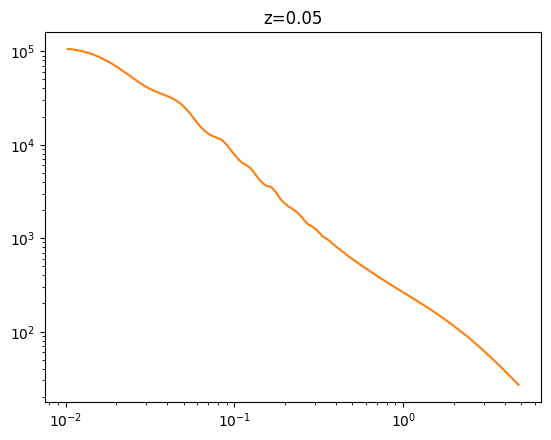

In [26]:
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/production_run/merged"
k = np.load(parent_dir + "/k_0.npy")  # (262,)'')

from matplotlib import pyplot as plt
plt.plot(k, Pz[0])
plt.plot(k, P_fid[0])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.05')

print (Pz[0])



Text(0.5, 1.0, 'z=0.0')

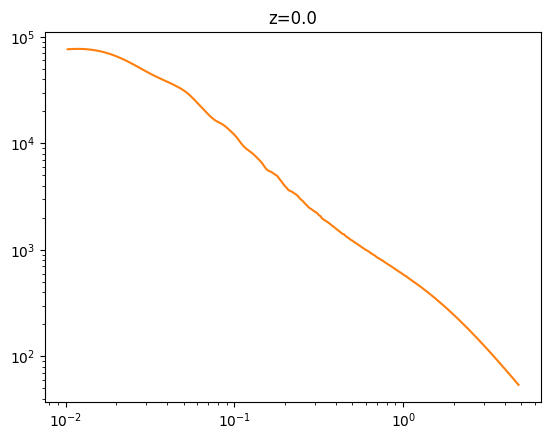

In [6]:
plt.plot(k, Pz[99])
plt.plot(k, pk_all[:,::-1][28,99])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.0')

In [9]:
Pz[0]

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na